In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import math
import ptitprince as pt

In [37]:
import popoff
from Session import SessionLite
from mpl_toolkits.mplot3d import Axes3D
from linear_model import PoolAcrossSessions, LinearModel, pca_session, LabelEncoder
import loadpaths
from scipy import stats, signal
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.decomposition import PCA

figure_path = '/home/jrowland/mnt/qnap/Figures/bois'

In [38]:
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rc("axes.spines", top=False, right=False) # despine

plt.rcParams.update(params)

COLORS = [
'#228E5E', # Hit green
'#DB3713', # Miss red
]

In [6]:
remove_targets = False
pas = PoolAcrossSessions(save_PCA=False, remove_targets=remove_targets, 
                         subsample_sessions=False, remove_toosoon=True)
lm = pas.linear_models[0]
pas.sessions

short post time
short post time
short post time
short post time
short post time
short post time
short post time
ALERT SESSIONS NOT SUBSAMPLED
short post time
short post time
short post time
short post time
short post time
short post time
short post time


{3: instance Mouse J064, run 10 of Session class,
 4: instance Mouse J064, run 11 of Session class,
 5: instance Mouse J064, run 14 of Session class,
 6: instance Mouse RL070, run 28 of Session class,
 7: instance Mouse RL070, run 29 of Session class,
 2: instance Mouse J063, run 9 of Session class,
 1: instance Mouse J065, run 11 of Session class}

In [39]:
print(pas.plot_string(is_plot=False))

Hello Adam
Remove targets is False.
Remove too soon is True
Here are the sessions in play:
['Mouse J064, run 10', 'Mouse J064, run 11', 'Mouse J064, run 14', 'Mouse RL070, run 28', 'Mouse RL070, run 29', 'Mouse J063, run 9', 'Mouse J065, run 11']
pre-frames spans -1.97 to -0.07 inclusive
post-frames spans 0.83 to 1.77 inclusive


In [40]:
# Naughty naughty global variable
covs_keep = ['mean_pre', 'corr_pre',  'largest_PC_var', 'flat', 'lick', 'reward',
             'reward_history', 'trial_number', 'n_cells_stimmed',
             'variance_cell_rates', 'largest_singular_value', 'largest_factor_var', 'ts_s1_pre', 'ts_s2_pre',
             'ts_both_pre']
            

In [41]:
def get_covariates(lm, region, outcomes=['hit'], remove_easy=False):
    
    covariate_dict, y = lm.prepare_data('all', 'partial',
                            outcomes=outcomes,
                            region=region, return_matrix=False, remove_easy=remove_easy)
    
            
    covariate_dict['y'] = y
    

    
    return {k:v for k,v in covariate_dict.items() if k in covs_keep}

In [42]:
no_norm = lambda x:x

In [43]:
def session_propagation(lm, cov_name, norm_func=stats.zscore):
    
    outcomes_keep = ['hit']
    remove_easy = True
    
    outcomes = lm.session.outcome

    # Get the S1 covariates
    covariate_dict = get_covariates(lm, 's1', outcomes=outcomes_keep, remove_easy=remove_easy)
    
    if cov_name != 'all':
        s1_covariate = norm_func(covariate_dict[cov_name])
    else:
        # Keep an eye on this
        s1_covariate = np.vstack([norm_func(v) for v in covariate_dict.values()])

    # Get the S2 activity
    trial_bool = np.isin(outcomes, outcomes_keep)
    if remove_easy:  # DO you wana include easys?
        test_and_catch = lm.session.photostim != 2
        trial_bool = np.logical_and(trial_bool, test_and_catch)

    flu = lm.flu[lm.region_map['s2'], :, :]
    flu = flu[:, trial_bool, :]
    
    s2_vector = (np.mean(flu[:, :, lm.frames_map['post']], (0,2)) - 
                 np.mean(flu[:, :, lm.frames_map['pre']], (0,2)))
    
    s2_vector = norm_func(s2_vector)
    
    return s1_covariate, s2_vector

In [44]:
def propagation_plot(cov_name, norm_func=stats.zscore):
    
    s1_vector = []
    s2_vector = []

    for lm in pas.linear_models:
        
        io = session_propagation(lm, cov_name, norm_func=norm_func)
        s1_vector.append(io[0])
        s2_vector.append(io[1])
        
    s1_vector = np.concatenate(s1_vector)
    s2_vector = np.concatenate(s2_vector)

    plt.plot(s1_vector, s2_vector, '.', color='black', alpha=1)
    
    # Plot the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(s1_vector, s2_vector)
    x_lims = (min(s1_vector), max(s1_vector))
    y_lims = (min(s2_vector), max(s2_vector))
    x = np.linspace(x_lims[0], x_lims[1], 3)
    plt.plot(x, intercept + slope * x, '-', color='black')
    plt.text(x_lims[1]/1.5, (y_lims[1] + y_lims[0])/1, 
             f'r^2 = {round(r_value**2, 2)}\ngradient = {round(slope, 4)}\np={p_value:.2e}',
            fontsize=16)
#     pas.plot_string(['There are only hit trials in this plot'])
    
    if norm_func == stats.zscore:
        add_str = ' z scored'
    else:
        add_str = ''
        
    plt.xlabel(cov_name + add_str)
    plt.ylabel('Change in activity in S2 \n' +  r'($\Delta$F/F)' + add_str)
    #     plt.savefig(os.path.join(figure_path, f'{cov_name}-proppy.pdf'),bbox_inches="tight")
#     plt.savefig(os.path.join(figure_path, f'{cov_name}-proppy.png'),bbox_inches="tight")

Labels will be encoded by hash table {'hit': 0}
Labels will be encoded by hash table {'hit': 0}
Labels will be encoded by hash table {'hit': 0}
Labels will be encoded by hash table {'hit': 0}
Labels will be encoded by hash table {'hit': 0}
Labels will be encoded by hash table {'hit': 0}
Labels will be encoded by hash table {'hit': 0}


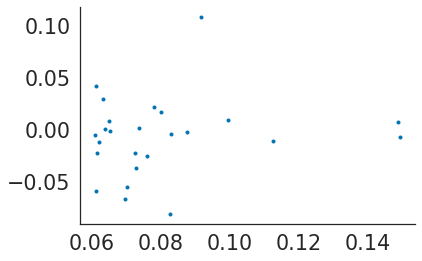

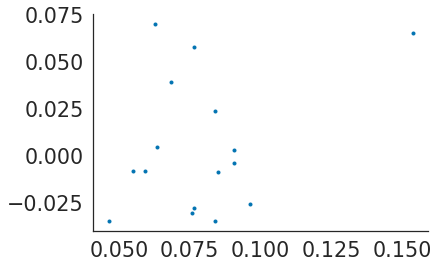

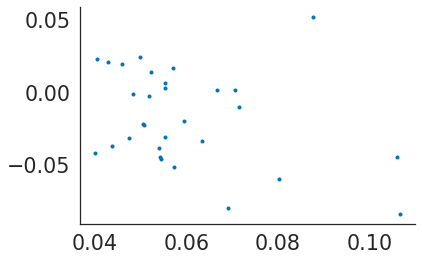

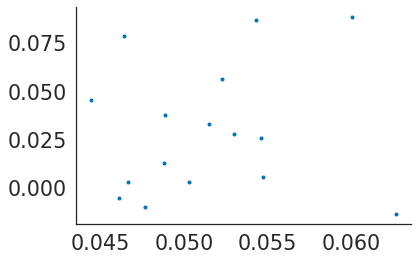

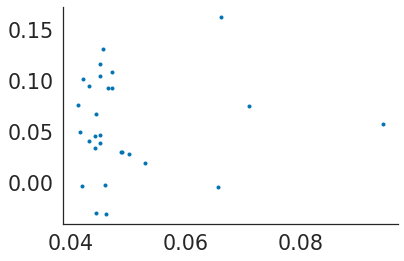

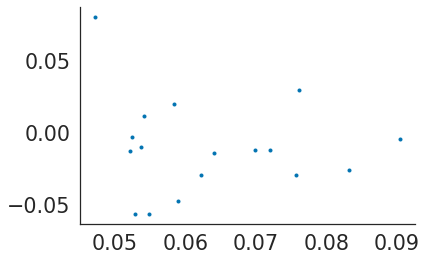

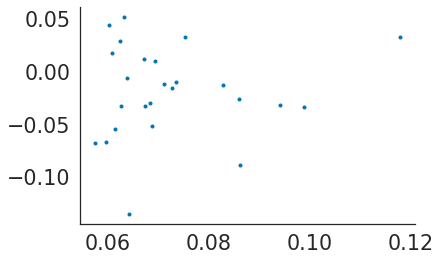

In [45]:
for lm in pas.linear_models:
    io = session_propagation(lm, cov_name, norm_func=no_norm)
    plt.figure()
    plt.plot(io[0], io[1], '.')
    

In [50]:
np.exp(-2)

0.1353352832366127

In [51]:
np.exp(-3)

0.049787068367863944

In [55]:
np.log(0.5)

-0.6931471805599453

In [68]:
np.log(0.5)

-0.6931471805599453

Labels will be encoded by hash table {'hit': 0}
Labels will be encoded by hash table {'hit': 0}
Labels will be encoded by hash table {'hit': 0}
Labels will be encoded by hash table {'hit': 0}
Labels will be encoded by hash table {'hit': 0}
Labels will be encoded by hash table {'hit': 0}
Labels will be encoded by hash table {'hit': 0}


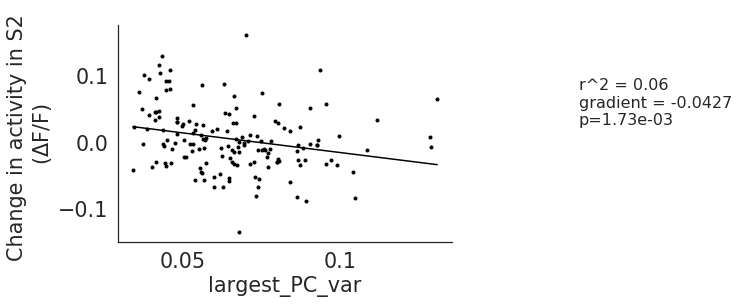

In [78]:
cov_name = 'largest_PC_var'
propagation_plot(cov_name, norm_func=no_norm)

plt.xticks([np.log(0.05), np.log(0.1)], [0.05, 0.1])
plt.savefig(os.path.join(figure_path, 'cuntycunty.pdf'))

In [16]:
def n_cells_stimmed_prop():
    
    norm_func = no_norm
    
    s1_vector = []
    s2_vector = []

    for lm in pas.linear_models:
        
        io = session_propagation(lm, 'n_cells_stimmed', norm_func=norm_func)
        s1_vector.append(io[0])
        s2_vector.append(io[1])
        
    s1_vector = np.concatenate(s1_vector)
#     s1_vector = np.array([mapper[n_cells] for n_cells in s1_vector])
    s2_vector = np.concatenate(s2_vector)
    
    for n_cells in np.unique(s1_vector):
        idx = np.where(s1_vector==n_cells)[0]
        plt.boxplot(s2_vector[idx], positions=[n_cells], widths=5)
        
#     plt.boxplot(s1_vector[idx], positions=s2_vector[idx])

    plt.axhline(0, linestyle=':')
    
    # Plot the regression line
    plt.xlabel('Number of Cells stimulated')
    plt.ylabel('Change in activity in S2 \n' +  r'($\Delta$F/F)')
    #     plt.savefig(os.path.join(figure_path, f'{cov_name}-proppy.pdf'),bbox_inches="tight")
#     plt.savefig(os.path.join(figure_path, f'{cov_name}-proppy.png'),bbox_inches="tight")

In [17]:
mapper = {5: 7.5,
          10: 7.5,
          20: 25,
          30: 25,
          40: 45,
          50: 45,
          150:150
}

Labels will be encoded by hash table {'hit': 0}
Labels will be encoded by hash table {'hit': 0}
Labels will be encoded by hash table {'hit': 0}
Labels will be encoded by hash table {'hit': 0}
Labels will be encoded by hash table {'hit': 0}
Labels will be encoded by hash table {'hit': 0}
Labels will be encoded by hash table {'hit': 0}


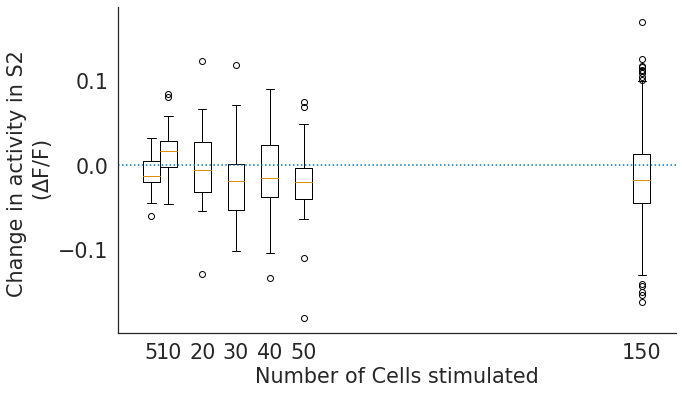

In [15]:
plt.figure(figsize=(10,6))
n_cells_stimmed_prop()

Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}


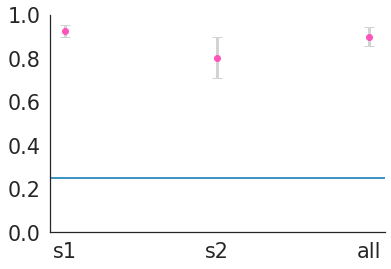

In [16]:
_, _, models = lm.compare_regions(frames='subbed', outcomes=['hit', 'fp'], plot=True)

Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'miss': 0, 'cr': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'miss': 0, 'cr': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'miss': 0, 'cr': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'miss': 0, 'cr': 1}
Mouse RL070, run 28
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'miss': 0, 'cr': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'miss': 0, 'cr': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'miss': 0, 'cr': 1}


Text(0, 0.5, 'Classification accuray')

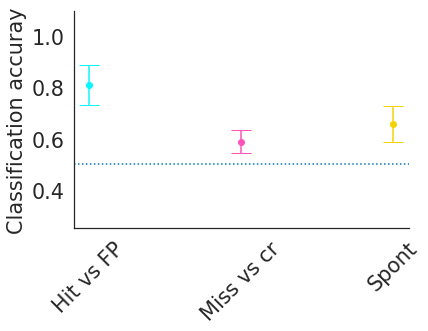

In [18]:
lm = pas.linear_models[0]
# _ = lm.project_model(frames='post', model='full', region='s2', plot=True)
pas.project_model(frames='post', model='full')
plt.ylim(0.25, 1.1)
plt.ylabel('Classification accuray')

Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Mouse RL070, run 28
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}


Text(0, 0.5, 'Classfier Performance')

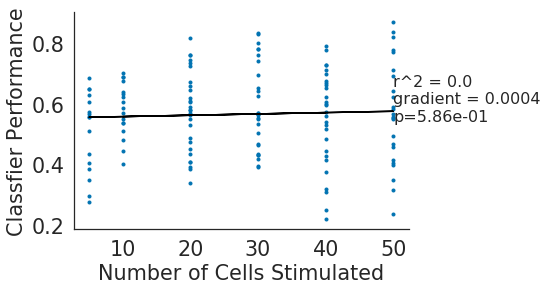

In [19]:
    
# plt.figure(figsize=(20,20))
# for idx, cov in enumerate(covs_keep):
#     plt.subplot(4,4,idx+1)
    
    
    
#     plt.title(cov)
#     _ = lm.performance_covariate_correlation(frames='post', covariate=cov, plot=True)
    
    
    
    
pas.performance_covariate_correlation(frames='post', covariate='n_cells_stimmed')
plt.xlabel('Number of Cells Stimulated')
plt.ylabel('Classfier Performance')

In [20]:
def plotty_prop(lm, covariate, plot=False):
    
    cov = []
    confidence = []
    for i in range(100):
        res = lm.performance_covariate_correlation(frames='post', covariate=covariate)
        cov.append(res[1])
        confidence.append(res[0])

    cov = np.array(cov)
    confidence = np.array(confidence)
    
    
    median=True

    if median:
        sort_idx = np.argsort(cov)
        cov = np.take_along_axis(cov, sort_idx, axis=1)
        
        confidence = np.take_along_axis(confidence, sort_idx, axis=1)
        
        x = np.median(cov, 0)
        y = np.median(confidence, 0)
    else:
        x = np.concatenate(cov, 0)
        y = np.concatenate(confidence, 0)
        
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    

    
    if plot:
        x_lims = (min(x), max(x))
        y_lims = (min(y), max(y))

        plt.plot(x, y, '.')
    
        plt.plot(x, intercept + slope * x, '-', color='black')
        plt.text((x_lims[0]+x_lims[1]) / 2, (y_lims[1] + y_lims[0])/2, 
                 f'r^2 = {round(r_value**2, 2)}\ngradient = {round(slope, 4)}\np={p_value:.2e}',
                 fontsize=16)

    return x,y

Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}


KeyboardInterrupt: 

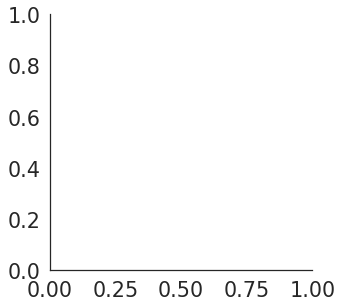

In [41]:
cov = 'variance_cell_rates'
plt.figure(figsize=(16,16))
for idx, lm in enumerate(pas.linear_models):
           
    plt.subplot(3,3,idx+1)
    try:
        plotty_prop(lm, covariate=cov, plot=True)
    except ValueError:
        continue
    plt.xlabel(cov)
    plt.ylabel('classifier caccuracy')

In [21]:
cov = 'variance_cell_rates'
x = []
y = []
for lm in pas.linear_models:
    try:
        xy = plotty_prop(lm, covariate=cov)
        x.append(xy[0])
        y.append(xy[1])
        
    except ValueError:
        continue
    
x = np.hstack(x)
y = np.hstack(y)

Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash 

Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash 

Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash 

Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash 

Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash 

Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash table {'hit': 0, 'fp': 1}
Labels will be encoded by hash 

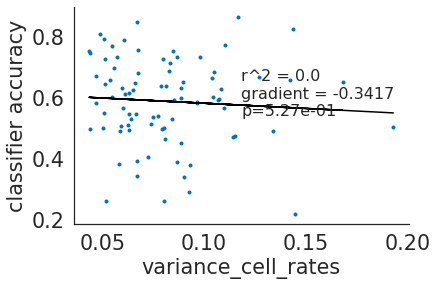

In [22]:
plt.plot(x, y, '.')

x_lims = (min(x), max(x))
y_lims = (min(y), max(y))


slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
plt.plot(x, intercept + slope * x, '-', color='black')
plt.text((x_lims[0]+x_lims[1]) / 2, (y_lims[1] + y_lims[0])/2, 
         f'r^2 = {round(r_value**2, 2)}\ngradient = {round(slope, 4)}\np={p_value:.2e}',
         fontsize=16)
plt.xlabel(cov)
plt.ylabel('classifier accuracy')
plt.savefig(os.path.join(figure_path, f'{cov}_propClassifier.pdf'))

In [ ]:
cov = 'variance_cell_rates'
lm.performance_covariate_correlation(cov)
plt.xlabel(cov)
plt.ylabel('classifier performance')
plt.title('Hit trials only')

In [ ]:
plt.figure(figsize=(16, 16))
n_plots = 0

for lm in pas.linear_models:
    n_plots += 1
    _, s2_delta = session_propagation(lm, 'mean_pre', norm_func=no_norm)
    
    ax = plt.subplot(3,4,n_plots)
    ax = pt.RainCloud(data = s2_delta, bw = .2, palette=[COLORS[0]],
                 width_viol = .5, ax = ax, orient = "v", showfliers=False, linecolor=[COLORS[0]])
    plt.xticks([0], ['Delta Activity S2'])
    plt.ylim(-0.1, 0.1)


In [ ]:
# Lasso regression model for all covariate
# Naughty naughty global variable
covs_keep = ['mean_pre', 'corr_pre', 'largest_PC_var', 'flat', 'lick', 'reward',
             'reward_history', 'trial_number', 'n_cells_stimmed',
             'variance_cell_rates', 'largest_singular_value', 'largest_factor_var']

In [ ]:

covs_keep = ['mean_pre', 'corr_pre', 'n_cells_stimmed']
             
            

In [ ]:
def regression_model(norm_func=stats.zscore):
    
    s1_vector = []
    s2_vector = []

    for idx, lm in enumerate(pas.linear_models):
        
        if idx == 0:
            continue

        io = session_propagation(lm, 'all')
        s1_vector.append(io[0])
        s2_vector.append(io[1])
        
    X = np.hstack(s1_vector)
    y = np.hstack(s2_vector)
    
    model = Lasso(alpha=1e-3)
    model.fit(X.T, y)
    
    # Plot each fold's betas as points
    x_pos = 0
    
    for label, beta in zip(covs_keep, model.coef_):
        plt.plot(x_pos, beta, '.', color=COLORS[0], label=label, markersize=9)
        x_pos += 1
    plt.xticks(np.arange(len(covs_keep)), covs_keep, rotation=90)

    plt.axhline(0, linestyle=':')

In [ ]:
regression_model()